In [56]:
import numpy as np

import pandas as pd

import xarray as xr

import glob

import matplotlib as mpl

import matplotlib.pyplot as plt

import math as mt

from math import e

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint

from scipy.signal import hilbert
import statistics
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Read GFDL files

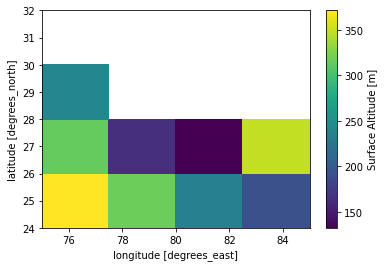

In [3]:
#Read Orography
I_OroData = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/orog_fx_GFDL-CM4_historical_r1i1p1f1_gr2.nc')
Ioro=I_OroData.orog.sel(lat=slice(24,32),lon=slice(74,86))
#Ioro.plot()
#Create Mask
Ioro.values[Ioro.values>500.1]=np.NaN
Imask=Ioro.values/Ioro.values
Ioro.plot()

# GFDL T2m and T2m hilbert

In [4]:
#Read Data
I_t2mData= xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/tas_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
time1=I_t2mData.indexes['time'].to_datetimeindex()
I_t2mData=I_t2mData.assign_coords(time=("time", time1))
It2mD = I_t2mData.sel(lat=slice(24,32),lon=slice(74,86))

<ipython-input-4-a1b3ce1b45ee>:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time1=I_t2mData.indexes['time'].to_datetimeindex()


In [5]:

#Mask data
It2mD.tas.values=It2mD.tas.values*Imask
# area avg
It2mTS=It2mD.mean(dim=['lat','lon'], skipna=True).tas
#Hilbert transform
It2m_hb = np.imag(hilbert(It2mTS.values,axis=0))
It2m_hb_ds = xr.Dataset({'It2m_hb': (('time'), It2m_hb)}, coords={'time': It2mTS.time})
#ISelect only Dec Jan months
It2m=It2mTS[((It2mTS.time.dt.month>11) | (It2mTS.time.dt.month<2))]
It2mhb=It2m_hb_ds.It2m_hb[((It2m_hb_ds.time.dt.month>11) | (It2m_hb_ds.time.dt.month<2))] 


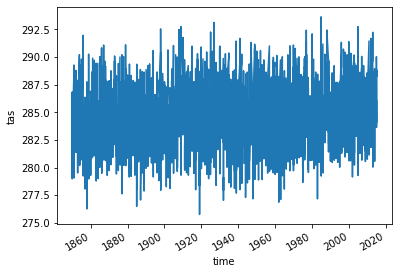

In [6]:
It2m.plot()

# GFDL wind speed and wind speed hilbert

In [7]:
# Read data
Iu10Data = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/uas_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
Iv10Data = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/vas_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
Iu10Data=Iu10Data.assign_coords(time=("time", time1))
Iv10Data=Iv10Data.assign_coords(time=("time", time1))

Iu10D = Iu10Data.sel(lat=slice(24,32),lon=slice(74,86))
Iv10D = Iv10Data.sel(lat=slice(24,32),lon=slice(74,86))
# Calculate wind speed
Iws = ((Iv10D.vas.values**2)+(Iu10D.uas.values**2))**0.5
Iws_ds = xr.Dataset({'Iws': (('time','lat','lon'), Iws)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Mask
Iws_ds.Iws.values=Iws_ds.Iws.values*Imask
# area avg
IwsTS=Iws_ds.mean(dim=['lat','lon'], skipna=True).Iws
# hilbert
Iws_hb = np.imag(hilbert(IwsTS.values,axis=0))
Iws_hb_ds = xr.Dataset({'Iws_hb': (('time'), Iws_hb)}, coords={'time': IwsTS.time})
#Select Dec and Jan
Iws=IwsTS[((IwsTS.time.dt.month>11) | (IwsTS.time.dt.month<2))] 
Iwshb=Iws_hb_ds.Iws_hb[((Iws_hb_ds.time.dt.month>11) | (Iws_hb_ds.time.dt.month<2))]

# GFDL rh and rh hilbert

In [8]:
#Read Data
I_rhData= xr.open_mfdataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/hurs_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
I_rhData=I_rhData.assign_coords(time=("time", time1))

IrhD = I_rhData.sel(lat=slice(24,32),lon=slice(74,86))
IrhD.hurs.values=IrhD.hurs.values/100.0
#Mask data
IrhD.hurs.values=IrhD.hurs.values*Imask
# area avg
IrhTS=IrhD.mean(dim=['lat','lon'], skipna=True).hurs
#Hilbert transform
Irh_hb = np.imag(hilbert(IrhTS.values,axis=0))
Irh_hb_ds = xr.Dataset({'Irh_hb': (('time'), Irh_hb)}, coords={'time': IrhTS.time})
#ISelect only Dec Jan months
Irh=IrhTS[((IrhTS.time.dt.month>11) | (IrhTS.time.dt.month<2))]
Irhhb=Irh_hb_ds.Irh_hb[((Irh_hb_ds.time.dt.month>11) | (Irh_hb_ds.time.dt.month<2))] 


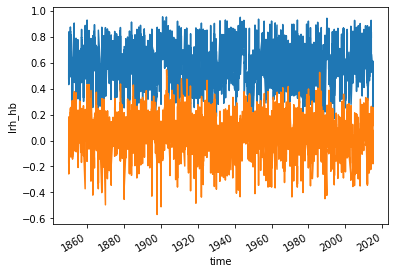

In [9]:
Irh.plot()
Irhhb.plot()

#  GFDL inv and inv hilbert

In [10]:
# Read 850 hPa t
I_tLevData= xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/ta_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
I_tLevData=I_tLevData.assign_coords(time=("time", time1))

It850D=I_tLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
It850D.ta.values=It850D.ta.values*Imask
# Calculate inv
Iinv = It2mD.tas.values-It850D.ta.values
Iinv_ds = xr.Dataset({'Iinv': (('time','lat','lon'), Iinv)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Iinv_ds.Iinv
#Mask
Iinv_ds.Iinv.values=Iinv_ds.Iinv.values*Imask
# area avg
IinvTS=Iinv_ds.mean(dim=['lat','lon'], skipna=True).Iinv
# hilbert
Iinv_hb = np.imag(hilbert(IinvTS.values,axis=0))
Iinv_hb_ds = xr.Dataset({'Iinv_hb': (('time'), Iinv_hb)}, coords={'time': IinvTS.time})
#Select Dec and Jan
Iinv=IinvTS[((IinvTS.time.dt.month>11) | (IinvTS.time.dt.month<2))] 
Iinvhb=Iinv_hb_ds.Iinv_hb[((Iinv_hb_ds.time.dt.month>11) | (Iinv_hb_ds.time.dt.month<2))]



# GFDL w700 and w700 hilbert

In [11]:
# Read Data
I_w700Data= xr.open_mfdataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/wap_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
I_w700Data=I_w700Data.assign_coords(time=("time", time1))

Iw700D = I_w700Data.sel(lat=slice(24,32),lon=slice(74,86),plev=(70000))
#Mask data
Iw700D.wap.values=Iw700D.wap.values*Imask
# area avg
Iw700TS=Iw700D.mean(dim=['lat','lon'], skipna=True).wap
#Hilbert transform
Iw700_hb = np.imag(hilbert(Iw700TS.values,axis=0))
Iw700_hb_ds = xr.Dataset({'Iw700_hb': (('time'), Iw700_hb)}, coords={'time': Iw700TS.time})
#ISelect only Dec Jan months
Iw700=Iw700TS[((Iw700TS.time.dt.month>11) | (Iw700TS.time.dt.month<2))]
Iw700hb=Iw700_hb_ds.Iw700_hb[((Iw700_hb_ds.time.dt.month>11) | (Iw700_hb_ds.time.dt.month<2))] 

# GFDL ushear and ushear hilbert

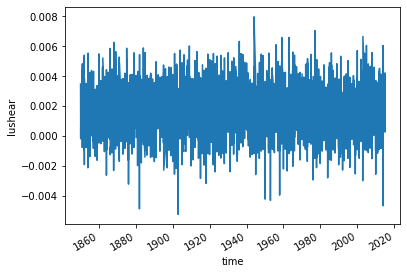

In [12]:
# Read 850 hPa u 
I_uLevData= xr.open_mfdataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/ua_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
I_uLevData=I_uLevData.assign_coords(time=("time", time1))

Iu850D=I_uLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
# Read 850 hPa  z 
I_zLevData= xr.open_mfdataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/zg_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
I_zLevData=I_zLevData.assign_coords(time=("time", time1))

Iz850D=I_zLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
# Calculate ushear
Iushear = (Iu850D.ua.values-Iu10D.uas.values)/(Iz850D.zg.values) 
Iushear_ds = xr.Dataset({'Iushear': (('time','lat','lon'), Iushear)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Iushear_ds.Iushear[0,:,:].plot()
#Mask
Iushear_ds.Iushear.values=Iushear_ds.Iushear.values*Imask
# area avg
IushearTS=Iushear_ds.mean(dim=['lat','lon'], skipna=True).Iushear
# hilbert
Iushear_hb = np.imag(hilbert(IushearTS.values,axis=0))
Iushear_hb_ds = xr.Dataset({'Iushear_hb': (('time'), Iushear_hb)}, coords={'time': IushearTS.time})
#Select Dec and Jan
Iushear=IushearTS[((IushearTS.time.dt.month>11) | (IushearTS.time.dt.month<2))] 
Iushearhb=Iushear_hb_ds.Iushear_hb[((Iushear_hb_ds.time.dt.month>11) | (Iushear_hb_ds.time.dt.month<2))]
Iushear.plot()

In [13]:
#IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0,
#                       It2mhb.values,Iwshb.values,Irhhb.values,Iinvhb.values,Iw700hb.values,Iushearhb.values]).T[:]
IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0]).T[:]



IX.index = pd.to_datetime(It2m.indexes['time'].values)
IX

,0,1,2,3,4,5
1850-01-01 12:00:00,281.170563,2.857837,0.475858,0.064063,0.075206,0.348170
1850-01-02 12:00:00,281.127075,2.620609,0.494671,1.994788,0.123534,0.305363
1850-01-03 12:00:00,280.278076,2.162122,0.533501,1.214884,0.137988,0.251060
1850-01-04 12:00:00,279.855591,1.671799,0.575366,0.092129,0.032001,0.134722
1850-01-05 12:00:00,280.085541,1.779952,0.566827,-0.621199,0.060838,0.040159
...,...,...,...,...,...,...
2014-12-27 12:00:00,286.354767,1.919871,0.436085,6.112681,-0.075453,0.144059
2014-12-28 12:00:00,284.849091,2.356346,0.421267,4.967092,-0.004761,0.026707
2014-12-29 12:00:00,283.925476,2.234227,0.386675,3.395288,0.109646,0.108399
2014-12-30 12:00:00,283.633789,1.821037,0.407832,0.964440,0.031921,0.131451


In [14]:
normI = StandardScaler().fit(IX)
    # transform training data
IX = normI.transform(IX)
IX

array([[-1.24304795,  1.43959869, -0.65820875, -1.09552945,  0.45239262,
         1.32469127],
       [-1.25998966,  1.08589428, -0.5333916 , -0.32624696,  0.88647504,
         1.01113317],
       [-1.5907395 ,  0.40229479, -0.27577506, -0.63699363,  1.0162958 ,
         0.61336897],
       ...,
       [-0.16979919,  0.50980322, -1.24989058,  0.23177113,  0.76173147,
        -0.4316158 ],
       [-0.28343351, -0.10625869, -1.10952237, -0.73678118,  0.06361266,
        -0.26276114],
       [ 0.65090507, -0.22238323, -1.14067925,  0.16851061, -1.42268165,
         0.03956585]])

In [136]:
reg = load('regGB_Obs.joblib') 
reg

GradientBoostingRegressor(learning_rate=0.04, min_samples_leaf=20,
                          n_estimators=300, random_state=0)

In [137]:
regLin=load('regLR_Obs.joblib')
regLin

LinearRegression()

In [138]:
y_ds=load('y_ds_Obs.joblib')
y_ds

<xarray.Dataset>
Dimensions:  (time: 2170)
Coordinates:
    expver   float64 1.0
  * time     (time) datetime64[ns] 1980-01-01T10:30:00 ... 2014-12-31T10:30:00
Data variables:
    y        (time) float64 0.32 0.4 0.4 0.36 0.32 ... 0.68 0.8 0.76 0.72 0.76

In [139]:
y_pred_ds=load('y_pred_ds_Obs.joblib')
y_pred_ds

<xarray.Dataset>
Dimensions:  (time: 2170)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    y_pred   (time) float64 0.2012 0.2858 0.3558 0.3774 ... 0.6405 0.6206 0.6037

In [140]:
y_predLin_ds=load('y_predLin_ds_Obs.joblib')
y_predLin_ds

<xarray.Dataset>
Dimensions:    (time: 2170)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    y_predLin  (time) float64 0.2822 0.383 0.3899 ... 0.5674 0.5565 0.4545

In [141]:
Iy_pred=reg.predict(IX)
Iy_predLin=regLin.predict(IX)
Iy_df = pd.DataFrame(Iy_pred)
Iy_df.index = pd.to_datetime(It2m.indexes['time'].values)
Iy_dfLin = pd.DataFrame(Iy_predLin)
Iy_dfLin.index = pd.to_datetime(It2m.indexes['time'].values)

In [142]:
Iy_ds=xr.Dataset({'Iy_pred': (('time'), Iy_pred)}, coords={'time': It2m.time})
Iy_ds

IyLin_ds=xr.Dataset({'Iy_predLin': (('time'), Iy_predLin)}, coords={'time': It2m.time})
IyLin_ds

<xarray.Dataset>
Dimensions:     (time: 10230)
Coordinates:
  * time        (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:0...
Data variables:
    Iy_predLin  (time) float64 0.2693 0.2748 0.3576 ... 0.116 0.1847 0.06519

(0.816141217070912, 0.0)

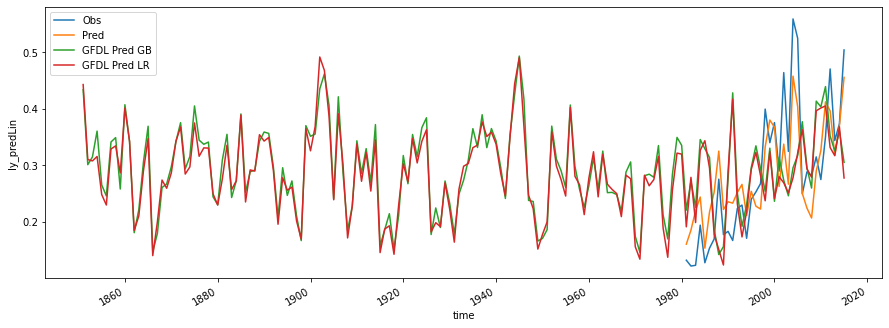

In [143]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')


Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time').plot(label='GFDL Pred GB')
IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time').plot(label='GFDL Pred LR')

plt.legend()
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)
#y_ds.y.values.corr(y_pred_ds.y_pred.values)

(0.816141217070912, 0.0)

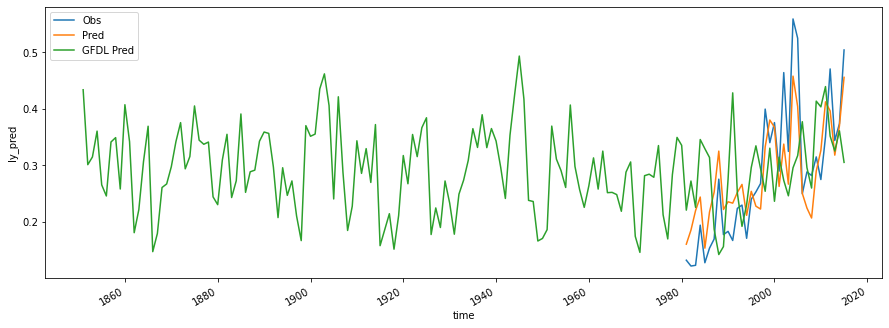

In [144]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')
Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time').plot(label='GFDL Pred')


plt.legend()
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)

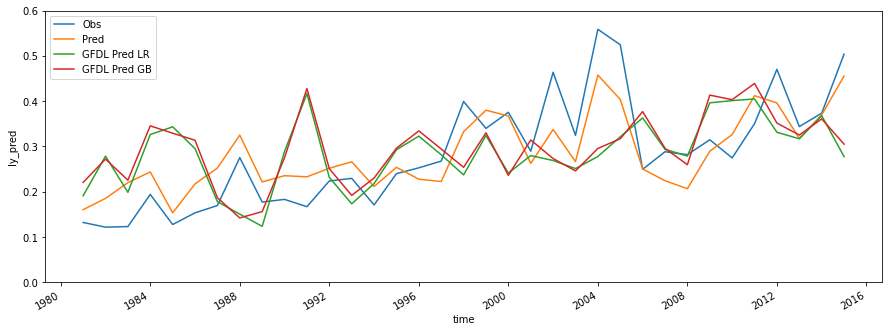

In [145]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')
IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time')[130:].plot(label='GFDL Pred LR')
Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time')[130:].plot(label='GFDL Pred GB')
plt.ylim(0, 0.6)
plt.legend()
plt.savefig('../GFDL_yearly.jpeg',dpi=300)

In [147]:
Widespread_Iy_pred=Iy_ds.Iy_pred.where(Iy_ds.Iy_pred > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_Iy_pred.sel(time=slice('1980-1-1','2014-12-31')).count())
# mean annual frequency
print(Iy_ds.Iy_pred.sel(time=slice('1980-1-1','2014-12-31')).where(Iy_ds.Iy_pred > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(Iy_ds.Iy_pred.sel(time=slice('1980-1-1','2014-12-31')).where(Iy_ds.Iy_pred > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()

<xarray.DataArray 'Iy_pred' ()>
array(429)
<xarray.DataArray 'Iy_pred' ()>
array(12.25714286)
<xarray.DataArray 'Iy_pred' ()>
array(8.8296347)


In [148]:
Widespread_Iy_predLin=IyLin_ds.Iy_predLin.where(IyLin_ds.Iy_predLin > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_Iy_predLin.sel(time=slice('1980-1-1','2014-12-31')).count())
# mean annual frequency
print(IyLin_ds.Iy_predLin.sel(time=slice('1980-1-1','2014-12-31')).where(IyLin_ds.Iy_predLin > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(IyLin_ds.Iy_predLin.sel(time=slice('1980-1-1','2014-12-31')).where(IyLin_ds.Iy_predLin > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()

<xarray.DataArray 'Iy_predLin' ()>
array(368)
<xarray.DataArray 'Iy_predLin' ()>
array(10.51428571)
<xarray.DataArray 'Iy_predLin' ()>
array(9.39413625)


In [146]:
print(np.corrcoef(y_ds.resample(time='1Y').mean().y,Iy_ds.resample(time='1Y').mean().Iy_pred[130:]))
print(np.corrcoef(y_ds.resample(time='1Y').mean().y,IyLin_ds.resample(time='1Y').mean().Iy_predLin[130:]))

[[1.         0.21831129]
 [0.21831129 1.        ]]
[[1.        0.2162438]
 [0.2162438 1.       ]]


obsTs=y_ds.resample(time='1M').mean().y.dropna(dim='time')
time1=obsTs["time"].dt.strftime("%m-%Y")
obsTs1=obsTs.assign_coords(time=("time", time1))


GBTs=Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time')[259:]
timeGB=GBTs["time"].dt.strftime("%m-%Y")
GBTs1=GBTs.assign_coords(time=("time", timeGB))
GBTs1

LinTs=IyLin_ds.resample(time='1M').mean().Iy_predLin.dropna(dim='time')[259:]
timeLin=LinTs["time"].dt.strftime("%m-%Y")
LinTs1=LinTs.assign_coords(time=("time", timeGB))
LinTs1



plt.figure(figsize=[15,5])
plt.plot(obsTs1.time.values,obsTs1.values,label='Obs')
plt.plot(GBTs1.time.values,GBTs1.values,label='GB_GFDL')
plt.plot(LinTs1.time.values,LinTs1.values,label='LR_GFDL')
plt.xticks(rotation=90)
plt.legend() 
#y_ds1.y.plot()

obsTs=y_ds.resample(time='1Y').mean().y.dropna(dim='time')
time1=obsTs["time"].dt.strftime("%Y")
obsTs1=obsTs.assign_coords(time=("time", time1))


GBTs=Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time')[259:]
timeGB=GBTs["time"].dt.strftime("%Y")
GBTs1=GBTs.assign_coords(time=("time", timeGB))
GBTs1

LinTs=IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time')[259:]
timeLin=LinTs["time"].dt.strftime("%Y")
LinTs1=LinTs.assign_coords(time=("time", timeGB))
LinTs1



plt.figure(figsize=[15,5])
plt.plot(obsTs1.time.values,obsTs1.values,label='Obs')
plt.plot(GBTs1.time.values,GBTs1.values,label='GB_GFDL')
plt.plot(LinTs1.time.values,LinTs1.values,label='LR_GFDL')
plt.xticks(rotation=90)
plt.legend() 
#y_ds1.y.plot()

In [149]:
# Read z500 data
Iz500Data_Orig = I_zLevData.sel(plev=50000)
#Iz500Data


# Calculate anomalies

In [150]:
climatology = Iz500Data_Orig.groupby("time.dayofyear").mean("time")
Iz500Data = Iz500Data_Orig.groupby("time.dayofyear") - climatology
#climatology
Iz500Data.time

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/numpy/core/_methods

<xarray.DataArray 'time' (time: 19800)>
array(['1850-01-01T12:00:00.000000000', '1850-01-02T12:00:00.000000000',
       '1850-01-03T12:00:00.000000000', ..., '2014-12-29T12:00:00.000000000',
       '2014-12-30T12:00:00.000000000', '2014-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
    plev       float64 5e+04
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365

In [153]:
Iy_ds.Iy_pred
Widespread_Iy1=Iy_ds.Iy_pred.where(Iy_ds.Iy_pred > 0.44, drop=True)
Widespread_Iy=Widespread_Iy1.sel(time=slice('1980-1-1','2014-12-31'))
totalCnt=Widespread_Iy.time.sizes
totalCnt
Widespread_Iy.time

<xarray.DataArray 'time' (time: 429)>
array(['1980-12-22T12:00:00.000000000', '1980-12-27T12:00:00.000000000',
       '1980-12-28T12:00:00.000000000', ..., '2014-01-19T12:00:00.000000000',
       '2014-01-20T12:00:00.000000000', '2014-01-26T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-12-22T12:00:00 ... 2014-01-26T12:00:00

In [154]:
time1=Widespread_Iy.time
time1

<xarray.DataArray 'time' (time: 429)>
array(['1980-12-22T12:00:00.000000000', '1980-12-27T12:00:00.000000000',
       '1980-12-28T12:00:00.000000000', ..., '2014-01-19T12:00:00.000000000',
       '2014-01-20T12:00:00.000000000', '2014-01-26T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-12-22T12:00:00 ... 2014-01-26T12:00:00

In [155]:
zwide=Iz500Data.sel(time=Widespread_Iy.time,method="nearest")
zwide

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lon: 144, time: 429)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-22T12:00:00 ... 2014-01-26T12:00:00
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    plev       float64 5e+04
    dayofyear  (time) int64 357 362 363 2 3 12 13 14 ... 9 10 16 17 18 19 20 26
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    zg         (time, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>

In [156]:
zwidePos=zwide.zg.where(zwide.zg.sel(lat=slice(20,40),lon=slice(60,85)).mean(dim=['lat','lon']) > 0.0, drop=True)
PosCnt=zwidePos.time.sizes

In [157]:
zwideNeg=zwide.zg.where(zwide.zg.sel(lat=slice(20,40),lon=slice(60,85)).mean(dim=['lat','lon']) < 0.0, drop=True)
NegCnt=zwideNeg.time.sizes

In [158]:
zwideAll=zwide.zg.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zwideAll

In [159]:
zNeg=zwideNeg.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zNeg

zPos=zwidePos.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zPos

In [160]:
zwideNeg

<xarray.DataArray 'zg' (time: 132, lat: 90, lon: 144)>
dask.array<where, shape=(132, 90, 144), dtype=float32, chunksize=(1, 90, 144), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1980-12-22T12:00:00 ... 2013-12-22T12:00:00
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    plev       float64 5e+04
    dayofyear  (time) int64 357 2 3 349 361 362 1 ... 349 350 28 349 350 351 356

In [161]:
zwidePos

<xarray.DataArray 'zg' (time: 297, lat: 90, lon: 144)>
dask.array<where, shape=(297, 90, 144), dtype=float32, chunksize=(1, 90, 144), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1980-12-27T12:00:00 ... 2014-01-26T12:00:00
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    plev       float64 5e+04
    dayofyear  (time) int64 362 363 12 13 14 29 339 339 ... 10 16 17 18 19 20 26

In [162]:
def map_plot(ax1):
    ax1.coastlines()
    ax1.set_xticks([20,40 , 60,80, 100,120, 140], crs=ccrs.PlateCarree())
    ax1.set_yticks([ 10, 20, 30, 40, 50, 60,70], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

In [163]:
# for contour labels
delta = 5.0
x = np.arange(-60, 60, delta)
y = np.arange(-60, 60, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'


class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


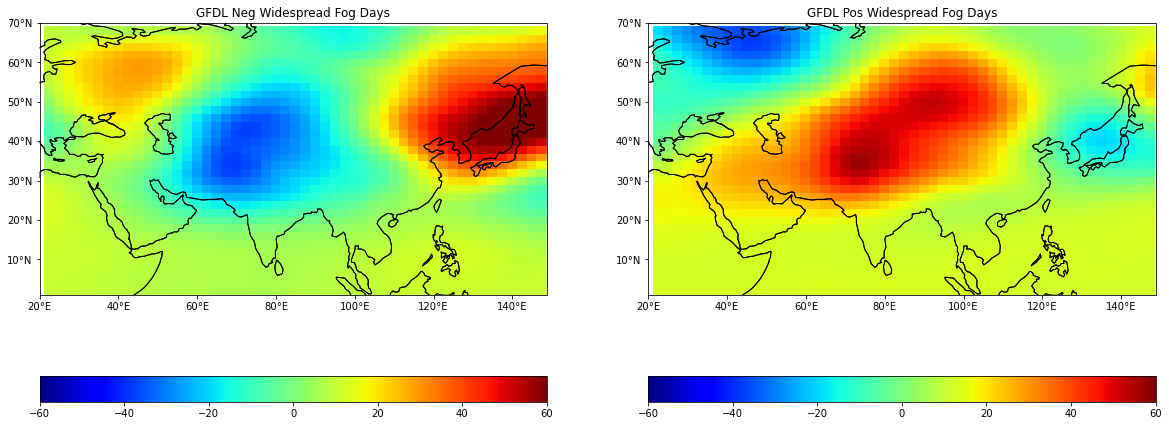

In [164]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(zNeg.lon.values,zNeg.lat.values,zNeg,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
ax1.set_title('GFDL Neg Widespread Fog Days')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())

m2=ax2.pcolor(zPos.lon.values,zPos.lat.values,zPos,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax2)
ax2.coastlines()
ax2.set_title('GFDL Pos Widespread Fog Days')

fig.colorbar(m2,orientation='horizontal')

plt.savefig('../GFDLWDF_pos_Neg.jpeg',dpi=300)


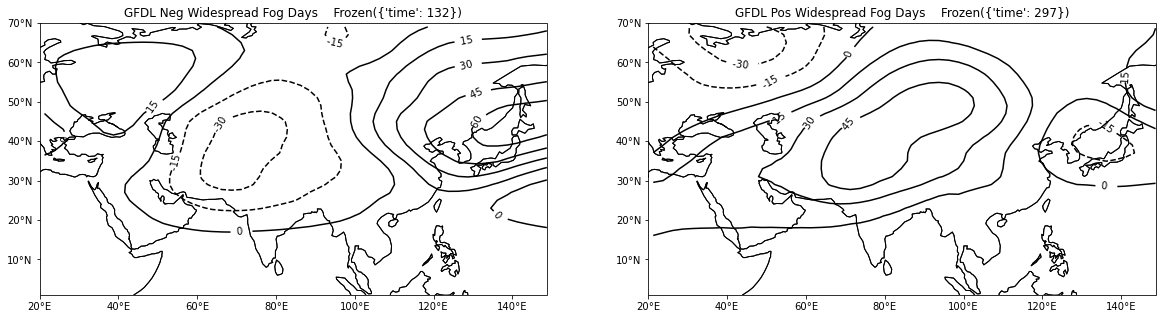

In [165]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zNeg.lon.values,zNeg.lat.values,zNeg,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title('GFDL Neg Widespread Fog Days'+"    "+str(NegCnt))
#fig.colorbar(m1,orientation='horizontal')


########## second Figure
ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
m2=ax2.contour(zPos.lon.values,zPos.lat.values,zPos,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
map_plot(ax2)
ax2.coastlines()

# Recast levels to new class
m2.levels = [nf(val) for val in m2.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax2.clabel(m2, m2.levels, inline=True, fmt=fmt, fontsize=10)

ax2.set_title('GFDL Pos Widespread Fog Days'+"    "+str(PosCnt))

#fig.colorbar(m2,orientation='horizontal')

plt.savefig('../GFDLWDF_pos_Neg.jpeg',dpi=300)


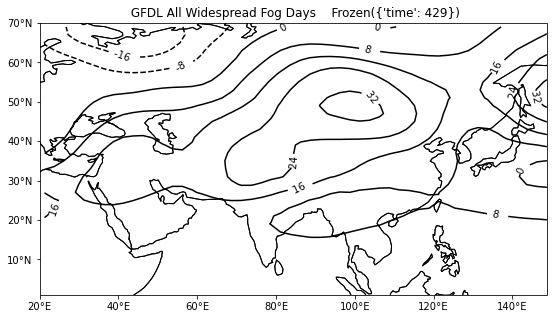

In [166]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zwideAll.lon.values,zwideAll.lat.values,zwideAll,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title(' GFDL All Widespread Fog Days'+"    "+str(totalCnt) )
#fig.colorbar(m1,orientation='horizontal')
plt.savefig('../GFDLWDF_All.jpeg',dpi=300)

# Read Low level fog Data  

In [167]:
I_lowCloudData= xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/cllcalipso_NDJFCFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')

In [168]:
time1=I_lowCloudData.indexes['time'].to_datetimeindex()
I_lowCloudData=I_lowCloudData.assign_coords(time=("time", time1))

<ipython-input-168-6bf47bd16fa2>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time1=I_lowCloudData.indexes['time'].to_datetimeindex()


In [169]:
#I_lowCloudData.cllcalipso[0,:,:].plot()

In [170]:
cloudwide=I_lowCloudData.sel(time=Widespread_Iy.time,method="nearest")
#cloudwide

In [171]:
cloudwideAll=cloudwide.cllcalipso.sel(lat=slice(5,40),lon=slice(60,100)).mean(dim='time')
#zwideAll


In [172]:
def map_plot_cloud(ax1):
    ax1.coastlines()
    ax1.set_xticks([70,75 , 80,85, 90,95, 100], crs=ccrs.PlateCarree())
    ax1.set_yticks([10,15 ,20, 25, 30, 35,40], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


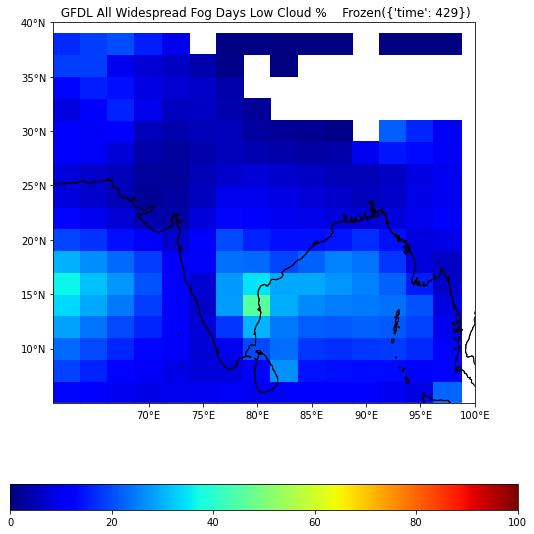

In [173]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(cloudwideAll.lon.values,cloudwideAll.lat.values,cloudwideAll,transform=ccrs.PlateCarree(),cmap='jet',vmax=100,vmin=0)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot_cloud(ax1)
ax1.coastlines()
# Recast levels to new class

ax1.set_title(' GFDL All Widespread Fog Days Low Cloud %'+"    "+str(totalCnt) )
fig.colorbar(m1,orientation='horizontal')
#fig.colorbar(m1,orientation='horizontal')
plt.savefig('../GFDLWDF_Cloud_All.jpeg',dpi=300)

In [174]:
Widespread_Iy1Ext=Iy_ds.Iy_pred.where(Iy_ds.Iy_pred > 0.56, drop=True)
Widespread_IyExt=Widespread_Iy1Ext.sel(time=slice('1979-12-1','2014-1-31'))
totalCnt=Widespread_IyExt.time.sizes
totalCnt
#cloudwideAllExt=cloudwideExt.cllcalipso.sel(lat=slice(5,40),lon=slice(60,100)).mean(dim='time')

Frozen({'time': 128})

In [175]:
cloudwideExt=I_lowCloudData.sel(time=Widespread_IyExt.time,method="nearest")
cloudwideAllExt=cloudwideExt.cllcalipso.sel(lat=slice(5,40),lon=slice(60,100)).mean(dim='time')

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


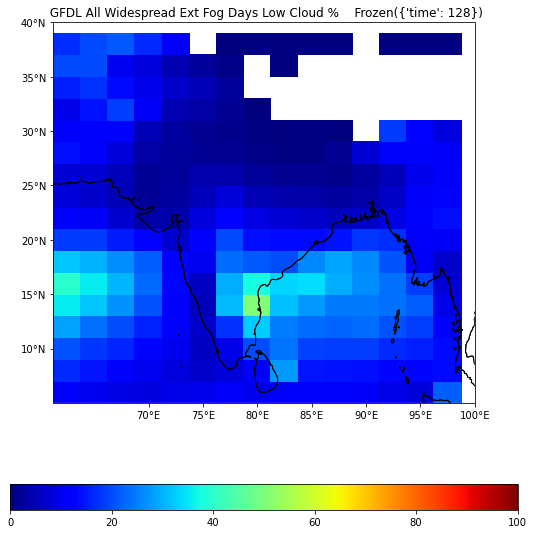

In [176]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(cloudwideAllExt.lon.values,cloudwideAllExt.lat.values,cloudwideAllExt,transform=ccrs.PlateCarree(),cmap='jet',vmax=100,vmin=0)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot_cloud(ax1)
ax1.coastlines()
# Recast levels to new class

ax1.set_title(' GFDL All Widespread Ext Fog Days Low Cloud %'+"    "+str(totalCnt) )
fig.colorbar(m1,orientation='horizontal')
#fig.colorbar(m1,orientation='horizontal')
plt.savefig('../GFDLWDF_Cloud_All.jpeg',dpi=300)

In [177]:
cloudwidePos=cloudwide.cllcalipso.where(zwide.zg.sel(lat=slice(20,40),lon=slice(60,85)).mean(dim=['lat','lon']) > 0.0, drop=True)
PosCnt=cloudwidePos.time.sizes


cloudwideNeg=cloudwide.cllcalipso.where(zwide.zg.sel(lat=slice(20,40),lon=slice(60,85)).mean(dim=['lat','lon']) < 0.0, drop=True)
NegCnt=cloudwideNeg.time.sizes


cloudeNeg=cloudwideNeg.sel(lat=slice(5,40),lon=slice(60,100)).mean(dim='time')
#zNeg

cloudePos=cloudwidePos.sel(lat=slice(5,40),lon=slice(60,100)).mean(dim='time')
#zPos


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3

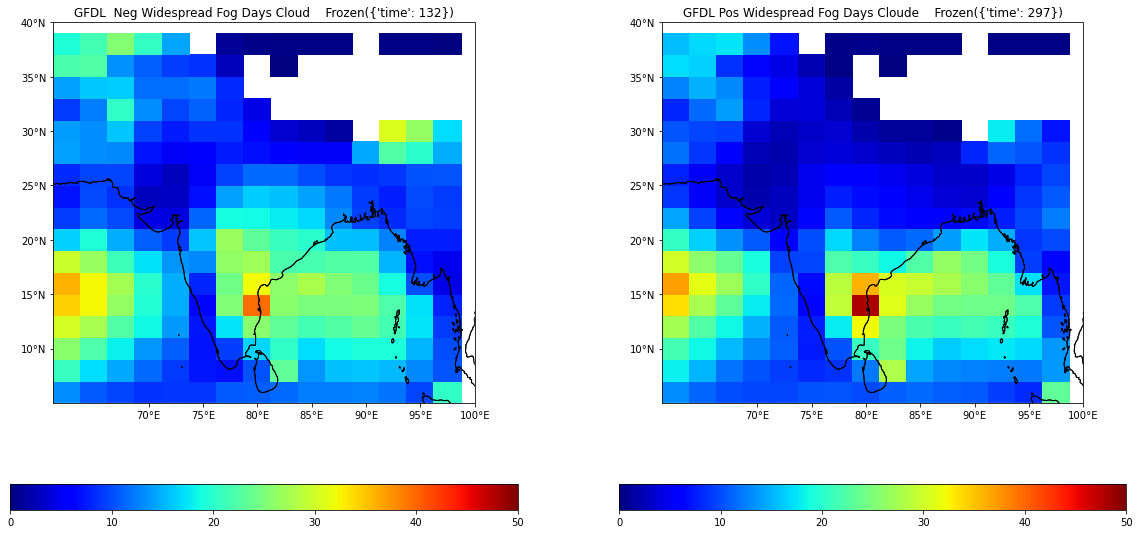

In [178]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(cloudeNeg.lon.values,cloudeNeg.lat.values,cloudeNeg,transform=ccrs.PlateCarree(),cmap='jet',vmax=50,vmin=0)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot_cloud(ax1)
ax1.coastlines()

ax1.set_title('GFDL  Neg Widespread Fog Days Cloud'+"    "+str(NegCnt))
#fig.colorbar(m1,orientation='horizontal')

fig.colorbar(m1,orientation='horizontal')
########## second Figure
ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
m2=ax2.pcolor(cloudePos.lon.values,cloudePos.lat.values,cloudePos,transform=ccrs.PlateCarree(),cmap='jet',vmax=50,vmin=0)
map_plot_cloud(ax2)
ax2.coastlines()




ax2.set_title('GFDL Pos Widespread Fog Days Cloude'+"    "+str(PosCnt))
fig.colorbar(m2,orientation='horizontal')
#fig.colorbar(m2,orientation='horizontal')

plt.savefig('../GFDLWDF_pos_Neg_cloud.jpeg',dpi=300)
